# System identification
In the file ``Data_collection.ipynb`` we tested the motor and collected the data points, which are stored in ``.csv`` files.

Now we use the dataset to determine the coefficients of the transfer function of the motor.

In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [54]:
def PWM2angle(pwm):
    return (pwm-1000)*180 / 1000

assert PWM2angle(1000) == 0
assert PWM2angle(2000) == 180
assert PWM2angle(1500) == 90

## Ramp

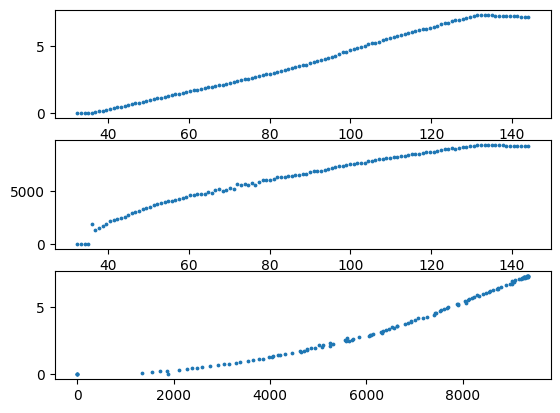

In [55]:
# Load the data
filename = 'Dataset_ramp.csv'
data = pd.read_csv(filename, sep=',')
data.describe()

# Split the columns
pwm = data['PWM'].to_numpy().reshape(-1,1)
angle = PWM2angle(pwm)
data['ANGLE'] = angle
rpm = data['RPM'].to_numpy().reshape(-1,1)
data['Thrust'] = data['Thrust'] * 9.81
thrust = data['Thrust'].to_numpy().reshape(-1,1)
#print(pwm.head())
#print(rpm.head())
#print(thrust.head())

fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.scatter(angle, thrust, s=3)
ax2.scatter(angle, rpm, s=3)
ax3.scatter(rpm, thrust, s=3)

If the motor saturated, remove the saturated samples

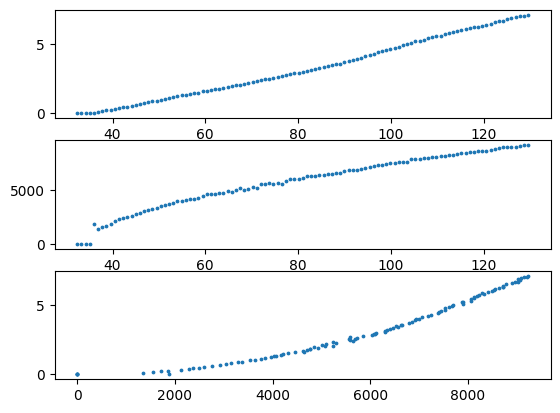

In [56]:
# Remove samples above the upper limit
upper_limit = 130
data = data[ data['ANGLE'] < upper_limit ]

# Split the columns
angle = data['ANGLE'].to_numpy().reshape(-1,1)
rpm = data['RPM'].to_numpy().reshape(-1,1)
thrust = data['Thrust'].to_numpy().reshape(-1,1)

# Check the plots
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.scatter(angle, thrust, s=3)
ax2.scatter(angle, rpm, s=3)
ax3.scatter(rpm, thrust, s=3)

[0.07622969696969693, -2.9154354545454524]


Text(0, 0.5, 'Thrust')

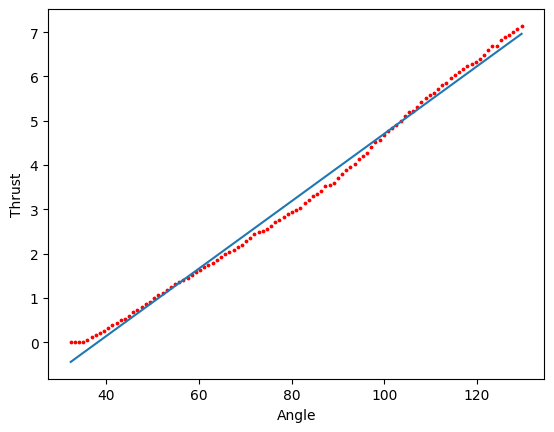

In [57]:
# Define the linear regression model
from sklearn import linear_model
linreg = linear_model.LinearRegression()

# Train the model on the dataset
linreg.fit(angle, thrust)
angle2thrust = [linreg.coef_.reshape(-1,1)[0][0], linreg.intercept_[0] ]
print(angle2thrust)

# Predict the values
predicted_thrust = linreg.predict(angle)

# Plot
fig, axes = plt.subplots()
axes.scatter(angle, thrust, s=3, color='red')
axes.plot(angle, predicted_thrust)
plt.xlabel('Angle')
plt.ylabel('Thrust')

8.419926339681897e-08


Text(0, 0.5, 'Thrust')

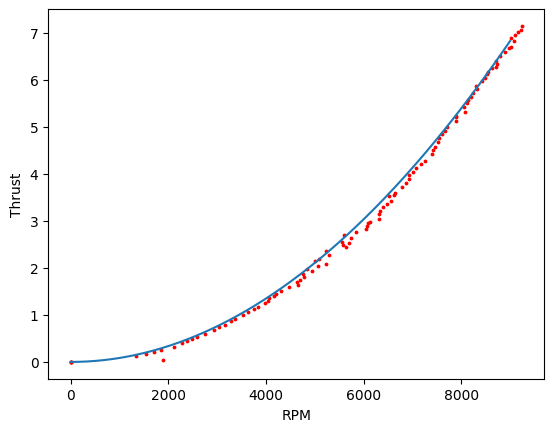

In [58]:
# Define the basic function for the rpm to thrust function
phi = np.power(rpm, [2])
#print(phi)
#assert phi.shape == (rpm.shape[0], 2)

# Train the model on the dataset
linreg.fit(phi, thrust)
w = linreg.coef_.reshape(-1,1)

# Build the polynomial
rpm2thrust_quad_coef = w[0][0]
print(rpm2thrust_quad_coef)
rpm2thrust = np.poly1d([rpm2thrust_quad_coef,0,0])
rpm_array = np.linspace(0,9000,9000)
thrust_array = rpm2thrust(rpm_array)

# Plot
fig, axes = plt.subplots()
axes.scatter(rpm, thrust, s=3, color='red')
axes.plot(rpm_array, thrust_array)
plt.xlabel('RPM')
plt.ylabel('Thrust')

[[   -93.18644226]
 [  3086.66540313]
 [-13957.49518391]]


Text(0, 0.5, 'RPM')

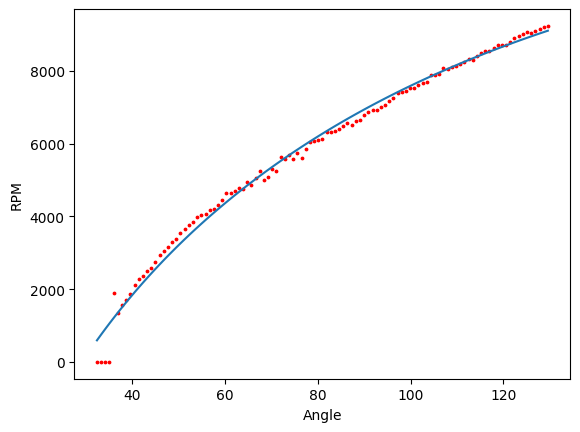

In [59]:
# Define the basic function for the rpm to thrust function
phi = np.power(angle, [1,0.5])
#print(phi)
#assert phi.shape == (angle.shape[0], 2)

# Train the model on the dataset
linreg.fit(phi, rpm)
angle2RPM_coefs = linreg.coef_[0].reshape(-1,1)
angle2RPM_coefs = np.vstack([angle2RPM_coefs, linreg.intercept_])
print(angle2RPM_coefs)

predicted_rpm = angle2RPM_coefs[0]*angle + angle2RPM_coefs[1]*np.power(angle, 0.5) + angle2RPM_coefs[2]

# Plot
fig, axes = plt.subplots()
axes.scatter(angle, rpm, s=3, color='red')
axes.plot(angle, predicted_rpm)
plt.xlabel('Angle')
plt.ylabel('RPM')

## Step response

In [60]:
# Load the data
filename = "Dataset_step.csv"
data = pd.read_csv(filename, sep=',')

# Convert time to seconds
data['T'] = data['T']/1000
data.describe()

,T,RPM
count,349.000000,349.000000
mean,2.222653,5622.470788
std,1.061959,751.819180
min,0.000000,0.000000
25%,1.319000,5305.040000
50%,2.275000,6056.324000
75%,3.134000,6079.644000
max,3.992000,6089.516000


The test is executed as follows:
- get the motor going for 2 seconds with a pwm command of 1220
- send a pwm command of 1500 for another 2 seconds to simulate a step input

To analyze the step response we need to:
- separate the two parts of the signal
- compute the steady state RPM of the first part and subtract it
- compute the steady state RPM of the second part and divide by it

By doing so we get the second part to be a signal starting from 0 and converging to 1, which is easier to analyze

Steady state rpm first part: 5305.209483146068
Steady state rpm second part: 6079.784851485148


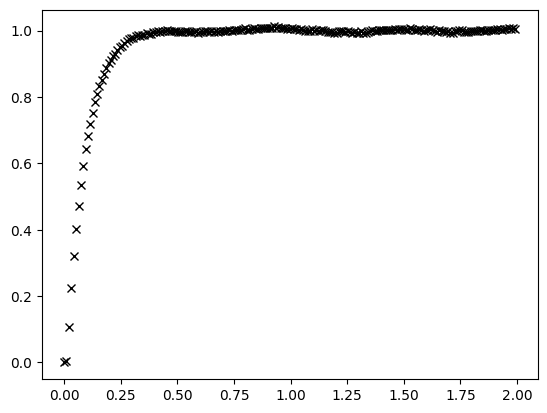

In [61]:
# Data collection parameters
time_threshold = 2
time_max = 4
baseline_angle = PWM2angle(1220)
step_angle = PWM2angle(1500)

# Split the dataset
data_first_part = data[ data['T'] < time_threshold ]
data_second_part = data[ data['T'] > time_threshold ]

# Steady state RPM values
ss_time_interval = 1    # how much time to consider
ss_first_part = data_first_part[ data_first_part['T'] > (time_threshold - ss_time_interval) ]['RPM'].mean()
ss_second_part = data_second_part[ data_second_part['T'] > (time_max - ss_time_interval) ]['RPM'].mean()
print(f"Steady state rpm first part: {ss_first_part}")
print(f"Steady state rpm second part: {ss_second_part}")

# To numpy
t = data_second_part['T'].to_numpy().reshape(-1,1)
rpm = data_second_part['RPM'].to_numpy().reshape(-1,1)

# Subtract the first part ss rpm and divide by the second part ss rpm (scaled accordingly)
rpm = (rpm - ss_first_part) / (ss_second_part - ss_first_part)

# Subtract the time threshold so the signal starts from 0
t -= time_threshold

# Add a (0,0) point
t = np.insert(t,0,0,axis=0)
rpm = np.insert(rpm,0,0,axis=0)

# Plot to check everything is right
fig, ax = plt.subplots()
ax.plot(t, rpm, 'kx')


We can observe that the step response has the typical structure of a second order system, with a dominant pole and a faster pole. So the output evolution is modeled as
$$y(t) = y(\infty) + Ae^{\alpha t} + Be^{\beta t}$$

Assuming $\beta \gg \alpha$ (so the mode related to $\beta$ decays quickly and can be ignored initially), we write the approximation
$$ y(t) - y(\infty) \simeq  Ae^{\alpha t} $$

In order to estimate $A$ and $\alpha$ with linear regression, we need to linearize the equation with the logarithm:
$$ ln(y(t) - y(\infty)) \simeq  ln(Ae^{\alpha t}) = ln(A) + \alpha t $$
Note that if A is negative (so $y(\infty) > y(t)$), we need to invert the difference:
$$ ln(y(\infty) - y(t)) \simeq  ln(|A|e^{\alpha t}) = ln(|A|) + \alpha t $$

Studying the plot we obtain we can extract the optimal values for $\alpha$, which is the slope of the line, and $ln(A)$, which is the intercept

29
A: -1.178181108779093	alpha: -12.824973174657465


/tmp/ipykernel_69624/2422172904.py:8: RuntimeWarning: invalid value encountered in log
  log_y_diff = np.log( y_inf - y )


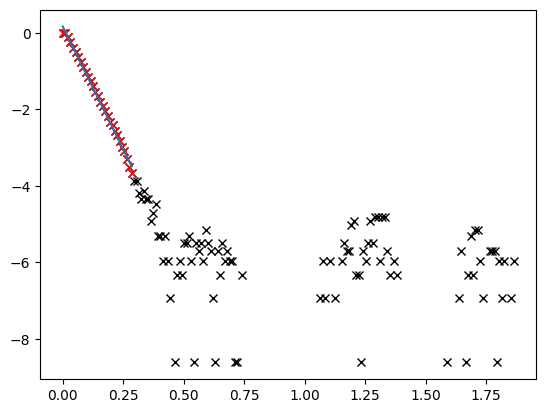

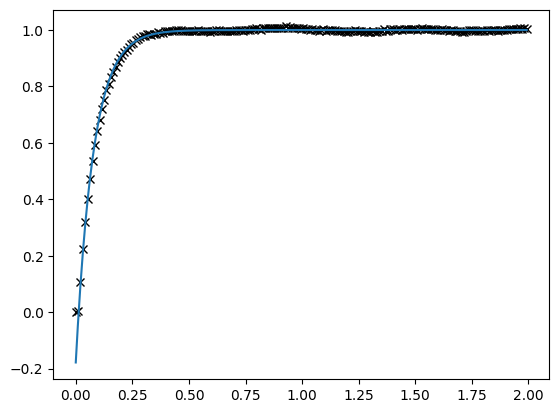

In [62]:
# We are in the case where A is negative

# Define y(t)=rpm and y(inf)=1
y = rpm
y_inf = 1       # Because we normalized the signal

# Compute the logarithm of the difference
log_y_diff = np.log( y_inf - y )

# Plot the log_diff
fig, ax = plt.subplots()
ax.plot(t, log_y_diff, 'kx')

# To reduce noise, consider only the first part of the signal
log_threshold = 0.3
indexes = np.where(t < log_threshold)       # Look where time is smaller than threshold
print(indexes[0][-1])                       # Index of the last element smaller than threshold
log_t = t[0:indexes[0][-1]]
log_y_diff = log_y_diff[0:indexes[0][-1]]
ax.plot(log_t, log_y_diff, 'rx')

# Linear regression
linreg.fit(log_t, log_y_diff)               # Fit the data
alpha = linreg.coef_[0][0]
A = -1 * np.exp(linreg.intercept_[0])          # We are in the case A < 0 
print(f"A: {A}\talpha: {alpha}")

# Check fit
ax.plot(log_t, linreg.predict(log_t))

# Check fit in the real response
fig,ax = plt.subplots()
ax.plot(t, y, 'kx')
ax.plot(t, y_inf + A*np.exp(alpha*t))

Now that we have the dominant pole, we can subtract its mode from the step response to obtain an approximation of the mode of the non-dominant pole
$$ y(t) - (y(\infty) + Ae^{\alpha t}) \simeq Be^{\beta t} $$

We apply the same procedure as before

5
B: 0.178181108779093	beta: -71.55075863214965


(0.0, 0.5)

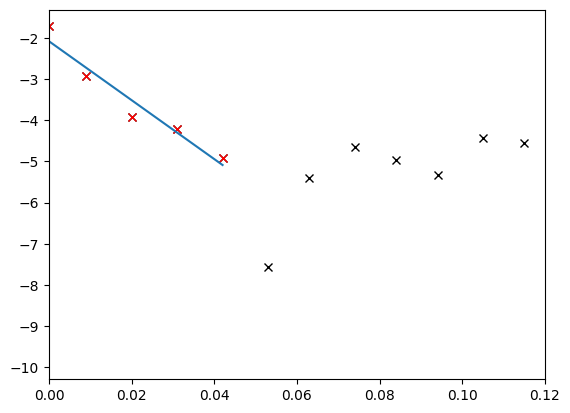

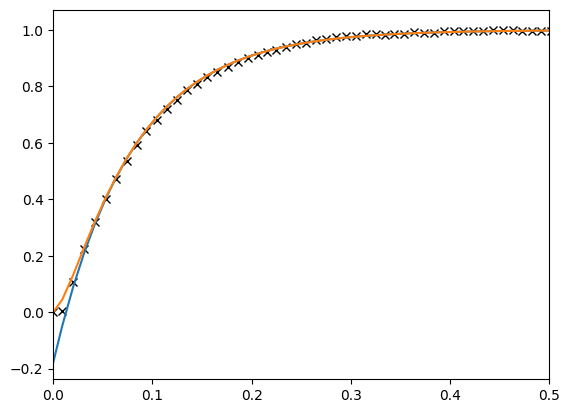

In [63]:
# Compute the logarithm of the difference
log_y_diff = np.log( abs( y - (y_inf + A*np.exp(alpha*t)) ) )

# Plot the log_diff
fig, ax = plt.subplots()
ax.plot(t, log_y_diff, 'kx')

# To reduce noise, consider only the first part of the signal
log_threshold = 0.06
indexes = np.where(t < log_threshold)       # Look where time is smaller than threshold
print(indexes[0][-1])                       # Index of the last element smaller than threshold
log_t = t[0:indexes[0][-1]]
log_y_diff = log_y_diff[0:indexes[0][-1]]
ax.plot(log_t, log_y_diff, 'rx')
ax.set_xlim([0,log_threshold*2])

# Linear regression
linreg.fit(log_t, log_y_diff)               # Fit the data
beta = linreg.coef_[0][0]
manual_intervention = True
B = np.exp(linreg.intercept_[0]) if manual_intervention==False else -A-1              # We are in the case B > 0 
print(f"B: {B}\tbeta: {beta}")

# Check fit
ax.plot(log_t, linreg.predict(log_t))

# Check fit in the real response
fig,ax = plt.subplots()
ax.plot(t, y, 'kx')
ax.plot(t, y_inf + A*np.exp(alpha*t))
ax.plot(t, y_inf + A*np.exp(alpha*t) + B*np.exp(beta*t))
ax.set_xlim([0,0.5])

#### Transfer function
The output equation (estimated) in the frequency domain is given by the laplace transform of the output response in the time domain
$$y(t) = y(\infty) + Ae^{\alpha t} + Be^{\beta t} \quad \Rightarrow \quad \hat{Y}(s) = \frac{1}{s} + \frac{A}{s-\alpha} + \frac{B}{s-\beta}$$

Common denominator:
$$ \hat{Y}(s) = \frac{(s-\alpha)(s-\beta) + As(s-\beta) + Bs(s-\alpha)}{s(s-\alpha)(s-\beta)} = \frac{(1 + A + B)s^2 + (-\alpha -\beta -A\beta -B\alpha)s - \alpha \beta}{s(s-\alpha)(s-\beta)}$$

To obtain the trasnfer function (rememebring that this is the step response) we divide by $\frac{1}{s}$:
$$ \hat{Y}(s) = \frac{1}{s} G(s) \quad \Rightarrow \quad G(s) = \frac{(1 + A + B)s^2 + (-\alpha -\beta -A\beta -B\alpha)s + \alpha \beta}{(s-\alpha)(s-\beta)}$$

Note that, in order to have a causal signal, the coefficient of $s^2$ in the numerator should be 0 (namely $A+B=-1$). This is not the case due to measurement errors and noise.

In [64]:
n2 = 1+A+B
n1 = -alpha -beta -A*beta - B*alpha
n0 = alpha*beta
numerator = np.poly1d([n2, n1, n0])
zeros = numerator.r

p1 = alpha
p2 = beta
poles = [p1,p2]
denominator = np.poly1d(poles, True)

print(f"Zeros: {zeros}, Poles: {poles}")

Zeros: [-388.64006511], Poles: [-12.824973174657465, -71.55075863214965]



   2.361 s + 917.6
---------------------
s^2 + 84.38 s + 917.6



(0.0, 0.5)

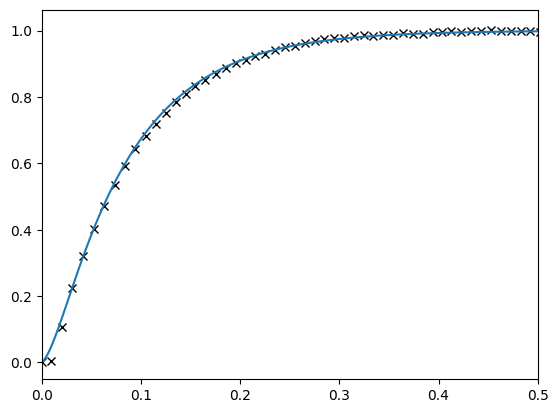

In [65]:
import control

# Transfer function of the motor
sysM_RPM_normalized = control.TransferFunction(numerator.c, denominator.c)
print(sysM_RPM_normalized)

# Check the static gain is equal to 1
assert sysM_RPM_normalized.dcgain() == 1

# Simulated step response
sim = control.step_response(sysM_RPM_normalized, squeeze=True)

# Plot
fig, ax = plt.subplots()
ax.plot(t,y,'kx')
ax.plot(sim.t, sim.y[0][0])
ax.set_xlim([0,0.5])


Revert the normalization process:
- the output is scaled back to the original value
- we compute the output difference (steady state output - baseline output)
- we compute the input difference (steady state input - baseline input)

The static gain of the transfer function is given by the ratio of output diff / input diff

Output difference: 774.5753683390794
Input difference: 50.4
Static gain: 15.368558895616657

 36.29 s + 1.41e+04
---------------------
s^2 + 84.38 s + 917.6



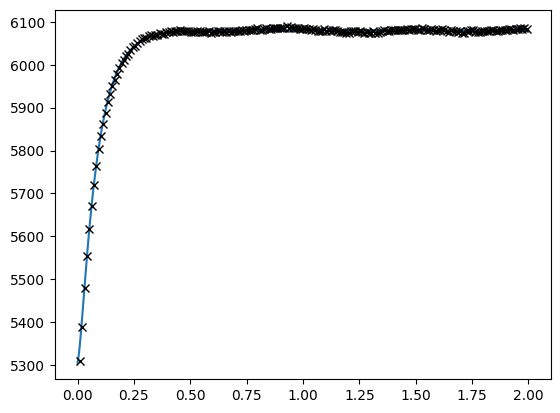

In [73]:
y_diff = ss_second_part - ss_first_part
u_diff = step_angle - baseline_angle
K = y_diff / u_diff
print(f"Output difference: {y_diff}")
print(f"Input difference: {u_diff}")
print(f"Static gain: {K}")

sysK = control.TransferFunction([K], [1])
sysM_RPM = control.series(sysK, sysM_RPM_normalized)
print(sysM_RPM)

# Compare our response with the original dataset
t_sim = np.linspace(0,2,2000)
u_sim = np.ones(np.shape(t_sim)) * u_diff
T, y_sim = control.forced_response(sysM_RPM, t_sim, u_sim)

y_sim += ss_first_part          # Add the baseline

fig, ax = plt.subplots()
ax.plot(t_sim, y_sim)
ax.plot(data_second_part['T'], data_second_part['RPM'], 'kx')


To obtain the trasnfer function from PWM to thrust we need to take into consideration the relationship from RPM to thrust.

We assume such relationship to be static. From the ramp response we can find the desired constant at the desired RPM.

We choose as working point the value of RPM that gives us a specific thrust, that is measured as the force applied by the weight of the whole arm at the distance where the motor is

Working point thrust: 2.38383
Working point angle: 69.51707359734137
Working point RPM: 5300.115142471961
K: 0.0008925315818289307
Angle to thrust transfer function: 
  0.03239 s + 12.59
---------------------
s^2 + 84.38 s + 917.6

Zeros: [-388.64006511+0.j]
Poles: [-71.55075863+0.j -12.82497317+0.j]


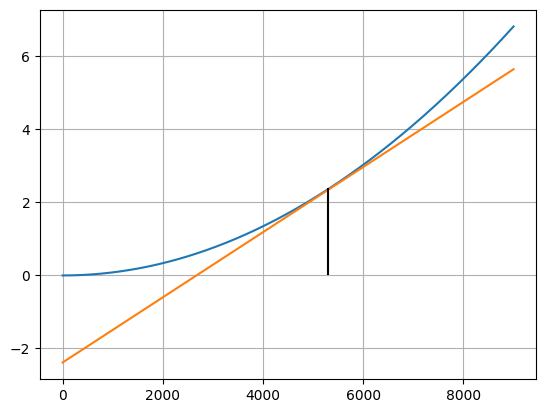

In [77]:
filename = "Operating_point.csv"
data_frame_op = pd.read_csv(filename)

operating_point_thrust = data_frame_op['OP'][0] * 9.81
operating_point_angle = (operating_point_thrust - angle2thrust[1]) / angle2thrust[0]
operating_point_RPM = (angle2RPM_coefs[0]*operating_point_angle + angle2RPM_coefs[1]*np.power(operating_point_angle, 0.5) + angle2RPM_coefs[2])[0]
print(f"Working point thrust: {operating_point_thrust}")
print(f"Working point angle: {operating_point_angle}")
print(f"Working point RPM: {operating_point_RPM}")

K = 2 * rpm2thrust_quad_coef * operating_point_RPM
print(f"K: {K}")
sysK = control.TransferFunction([K],[1])

sysM = control.series(sysK, sysM_RPM)

fig, ax = plt.subplots()
ax.plot(rpm_array, thrust_array)
ax.plot(rpm_array, K*rpm_array - operating_point_thrust)
ax.vlines([operating_point_RPM], 0, operating_point_thrust, 'k')
ax.grid(True)

print(f"Angle to thrust transfer function: {sysM}")
print(f"Zeros: {sysM.zeros()}")
print(f"Poles: {sysM.poles()}")